# Covid-19 infección en Ecuador. Modelos matemáticos y predicciones
Una comparación de modelos, lineal, polilnomico,logísticos y exponenciales aplicados a la infección por el virus Covid-19

Se realiza un análisis matemático simple del crecimiento de la infección en Python y dos modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de curva.

In [1]:
# Importar las librerias para el analasis

import plotly.graph_objects as go
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Actualizar los datos (URL)

url = 'http://cowid.netlify.com/data/full_data.csv'

df = pd.read_csv(url)
df

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,NaN,NaN,1,NaN
1,2020-02-26,Afghanistan,0.0,NaN,1,NaN
2,2020-02-27,Afghanistan,0.0,NaN,1,NaN
3,2020-02-28,Afghanistan,0.0,NaN,1,NaN
4,2020-02-29,Afghanistan,0.0,NaN,1,NaN
...,...,...,...,...,...,...
2862,2020-03-13,World,7488.0,338.0,132758,4956.0
2863,2020-03-14,World,9761.0,433.0,142534,5392.0
2864,2020-03-15,World,10967.0,343.0,153517,5735.0
2865,2020-03-16,World,13971.0,855.0,167506,6606.0


Imprimos los resultados y agregamos el numero del dia


In [3]:
df = df[df['location'].isin(['Ecuador'])] #Filtro la Informacion solo para Ecuador
df = df.loc[:,['date','total_cases']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)

df

,date,total_cases
681,60,1
682,61,1
683,62,6
684,63,7
685,64,7
686,65,13
687,66,14
688,67,14
689,68,15
690,69,15


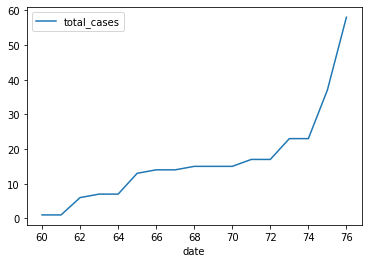

In [4]:
df.plot(x ='date', y='total_cases')

Ahora podemos analizar los cuatro modelos que tomaré en el examen, que son la función lineal, polinomica,logística y la función exponencial . Cada modelo tiene tres parámetros , que se estimarán mediante un cálculo de ajuste de curva en los datos históricos.

## EL modelo lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, lo que haremos es «dibujar una recta» que nos indicará la tendencia de un conjunto de datos continuos.

Recordemos rápidamente la fórmula de la recta:

Y = mX + b

Donde Y es el resultado, X es la variable, m la pendiente (o coeficiente) de la recta y b la constante o también conocida como el «punto de corte con el eje Y» en la gráfica (cuando X=0)
Ejemplo
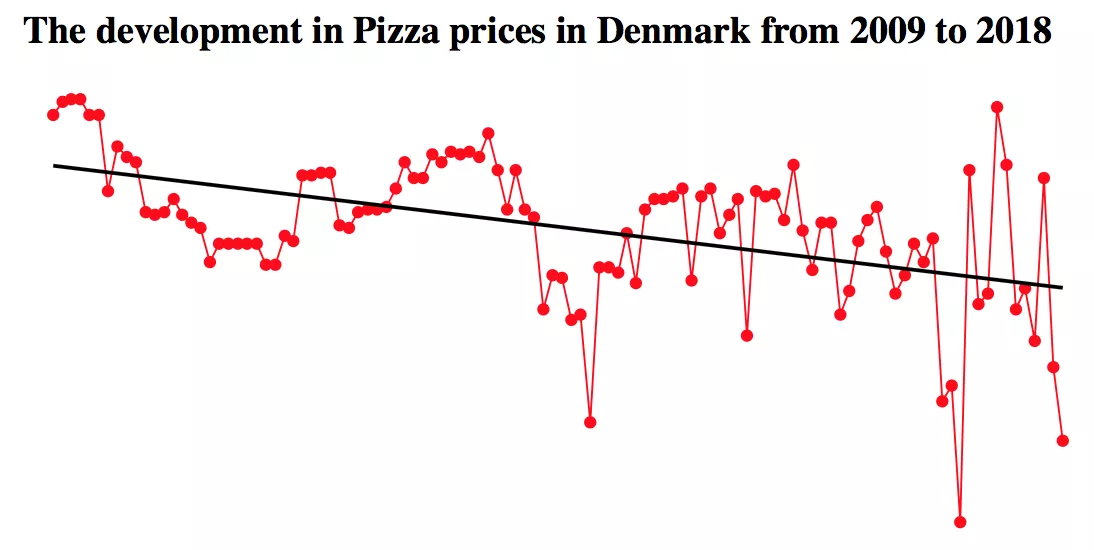

Recordemos que los algoritmos de Machine Learning Supervisados, aprenden por sí mismos y -en este caso- a obtener automáticamente esa «recta» que buscamos con la tendencia de predicción. Para hacerlo se mide el error con respecto a los puntos de entrada y el valor «Y» de salida real.



In [5]:
x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(np.array(x).reshape(-1, 1) ,y)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio

Coefficients: 
 [2.31617647]
Independent term: 
 -140.85294117647058


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [6]:
#Vamos a comprobar:
# Quiero predecir cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
y_prediccion = regr.predict([[100]])
print(int(y_prediccion))

90


[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]


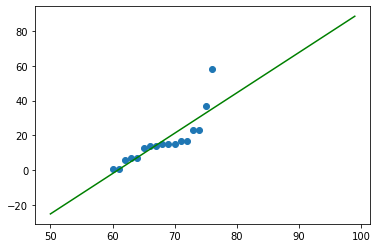

In [7]:
#Graficar
plt.scatter(x, y)
x_real = np.array(range(50, 100))
print(x_real)
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='green')
plt.show()



## El modelo logistico

El modelo logístico se ha utilizado ampliamente para describir el crecimiento de una población. Una infección puede describirse como el crecimiento de la población de un agente patógeno, por lo que un modelo logístico parece razonable .
La expresión más genérica de una función logística es:

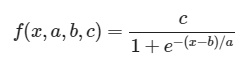

En esta fórmula, tenemos la variable x que es el tiempo y tres parámetros: a, b, c .

- a se refiere a la velocidad de infección
- b es el día en que ocurrieron las infecciones máximas
- c es el número total de personas infectadas registradas al final de la infección
 


A continuacion se puede apreciar un ejemplo de regresion logistica
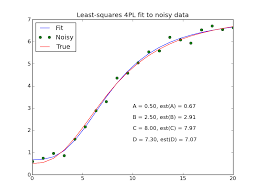

Definamos la función en Python y realicemos elprocedimiento de ajuste de curva utilizado para el crecimiento logístico.

In [8]:
def modelo_logistico(x,a,b):
    return a+b*np.log(x)

exp_fit = curve_fit(modelo_logistico,x,y)
print(exp_fit)


(array([-637.69367899,  155.1710206 ]), array([[11872.54041469, -2814.63865054],
       [-2814.63865054,   667.4662425 ]]))


## Graficas

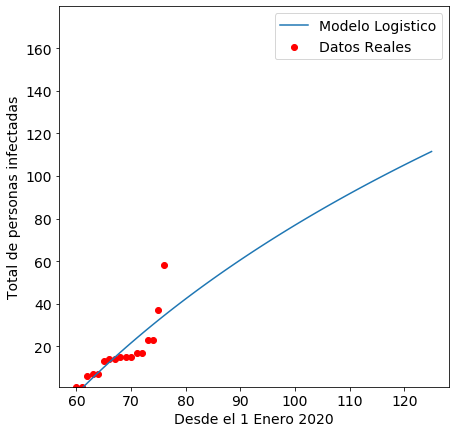

In [9]:
pred_x = list(range(min(x),max(x)+50))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Enero 2020")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*0.9,max(y)*3.1))
plt.show()

## Modelo exponencial

Mientras que el modelo logístico describe un crecimiento de infección que se detendrá en el futuro, el modelo exponencial describe un crecimiento de infección imparable . Por ejemplo, si un paciente infecta a 2 pacientes por día, después de 1 día tendremos 2 infecciones, 4 después de 2 días, 8 después de 3 y así sucesivamente.
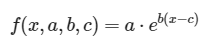

A continuacion se tiene un ejemplo de regresion exponencial
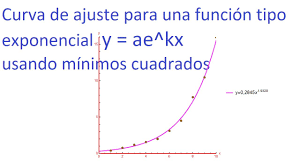

In [10]:
# Implementar
fecha=np.arange(1,len(x)+1,1)
casos = df.iloc [:, 1]
x=fecha
y=casos
def func(x, c, k):
    return (c*np.exp(k*x))
 
popt, pcov = curve_fit(func, x, y)




# Graficas

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=func(x,*popt), x=fecha,mode='lines',name='Prediccion'))
fig.add_trace(go.Scatter(y=casos, x=fecha,mode='lines',name='Datos Reales'))
fig.show()

In [12]:
barra=func(x,*popt)
trace0 = go.Bar(
    
    y=casos,
    name='Datos Reales',
    marker=dict(
        color='rgb(49,130,189)'
    )
)
trace1 = go.Bar(
    
    y=barra,
    name='Prediccion',
    marker=dict(
        color='rgb(204,204,204)',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
)

fig = go.Figure(data=data, layout=layout)
fig.show()

## Modelo polinomial
Predicción de una variable de respuesta cuantitativa a partir de una variable predictora cuantitativa, donde la relación se modela como una función polinomial de orden n (esto significa que pueden tener de diferentes exponenciales o grados y se debe ir probando)  

Se puede tener una ecuacion con diferentes grados

y = a0 + a1x + a2x^2 + a3x^3 + … + anx^n + ε

Ejemplo de una regresion polinomica de grado 4.
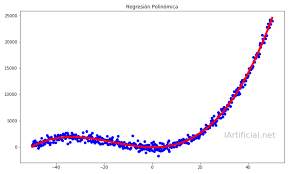


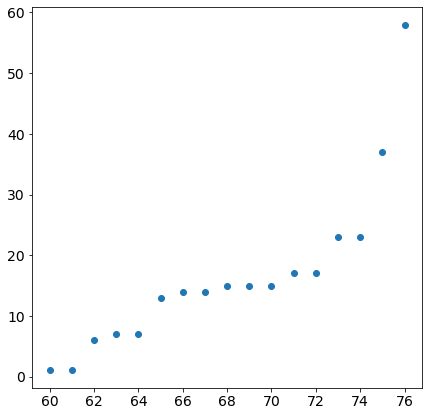


DATOS DEL MODELO REGRESIÓN POLINOMIAL

Valor de la pendiente o coeficiente "a":
[ 0.00000000e+00  2.98901656e+01  8.62903242e+02 -3.45986456e+01
  5.84242746e-01 -4.67042386e-03  1.45641321e-05]
Valor de la intersección o coeficiente "b":
-254506.07192066475


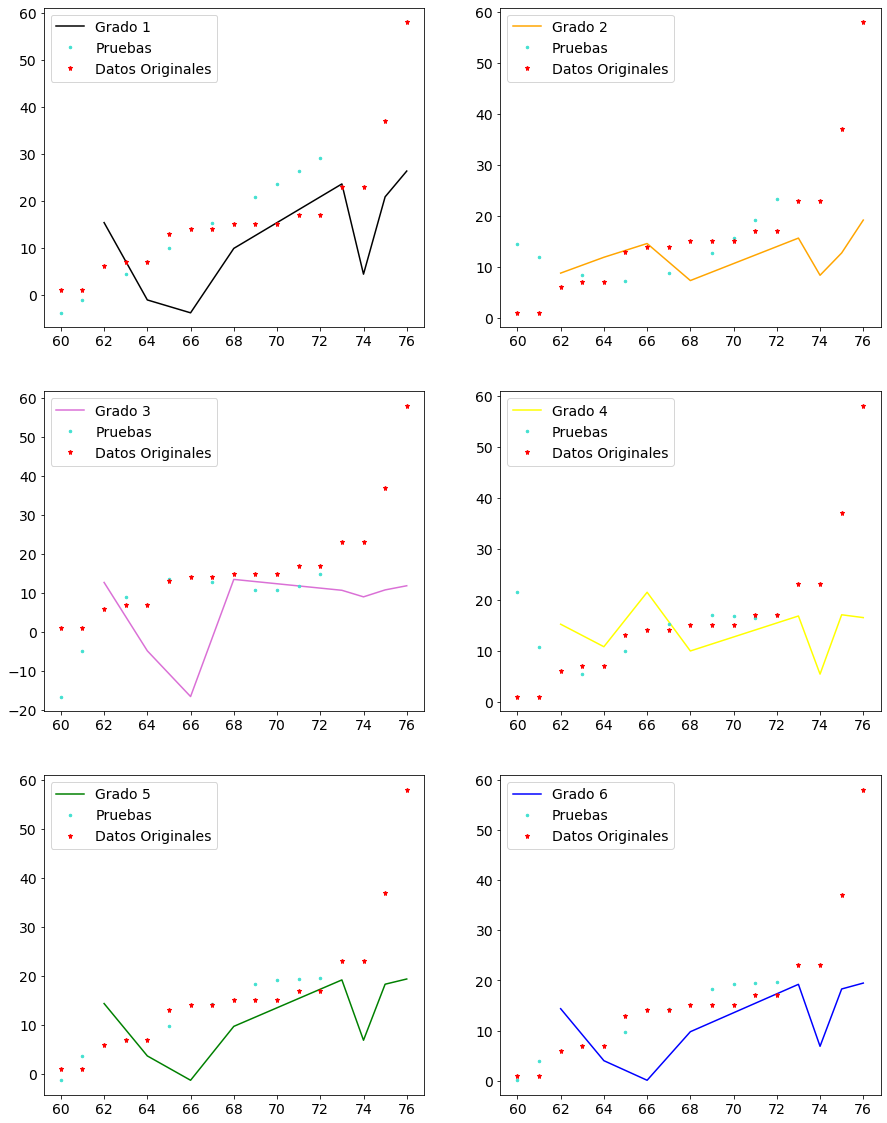

In [13]:
# Implementar 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
x = df['date']
y = df['total_cases']
x1 = df['date']
y1 = df['total_cases']
plt.scatter(x, y)
plt.show()
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.5)
X_train=X_train.values.reshape([X_train.values.shape[0],1])
X_test=X_test.values.reshape([X_test.shape[0],1])

titles=['Grado 0','Grado 1','Grado 2','Grado 3','Grado 4','Grado 5','Grado 6']
colors=['orange','black','orange','orchid','Yellow','green','blue']
plt.figure(figsize=(15,20))

for i in range(1,7):
    #Se define el grado del polinomio
    poly_features=PolynomialFeatures(degree=i)
    
    #Se transforma las características existentes en características de mayor grado
    X_poly=poly_features.fit_transform(X_train)
    Xt_poly=poly_features.fit_transform(X_test)
    #Defino el algoritmo a utilizar
    poly_model=LinearRegression()
    #Entreno el modelo
    poly_model.fit(X_poly,y_train)
    #Realizo una predicción
    pred=poly_model.predict(X_poly)
    pred2=poly_model.predict(Xt_poly)
    #Graficamos los datos junto con el modelo

    xt,yt=zip(*sorted(zip(X_test,pred2)))
    X,y=zip(*sorted(zip(X_train,pred2)))
    plt.subplot(3,2,i)
    plt.plot(X,y,'-',color=colors[i],label=titles[i],markersize=2)
    plt.plot(xt,yt,'.',color='turquoise',label='Pruebas',markersize=5)
    plt.plot(x1,y1,'*',color='red',label='Datos Originales',markersize=5)
    plt.legend(loc=2)
    
    
print()
print('DATOS DEL MODELO REGRESIÓN POLINOMIAL')
print()
print('Valor de la pendiente o coeficiente "a":')
print(poly_model.coef_)
print('Valor de la intersección o coeficiente "b":')
print(poly_model.intercept_)



## Analisis
Como se observa en las graficas existe una gran tasa de crecimiento de contagios en país, según la simulación del modelo exponencial la predicción se ajusta al doble de infectados por día, este modelo se ajusta mas a la realidad en predicción de datos en comparación con el modelo polinomial.

En el modelo exponencial se ajusta a la formal 

P(t)=P.e^Rt 

Donde:

P= contagiados en el primer día 

R= tasa de crecimiento diario  

t= unidad en función del tiempo en este caso días  


## Conclusiones

Al ser una ecuación exponencial la curva de predicción se ajusta mas a los datos de la realidad, a diferencia del modelo polinomial que usa ecuaciones de grado n, en este caso se debe probar que grado se ajusta mejor al modelo y predice mejor los datos, siendo esto menos preciso que el exponencial 

## Criterio personal (politico, economico y  social de la situacion)

Observando los resultados podemos decir que nuestro país es el peor de la zona en controlar la pandemia, siendo un país pequeño pudo controlar mejor el ingreso de personas al país realizando el cierre inmediato de las fronteras, también al primer brote del virus debió tomar mas prevenciones y realizar un cerco epidemiológico mas fuerte, dotar a las instituciones de salud de mas recursos para combatir la pandemia y esto se pude realizar bajando los sueldos de los trabajadores públicos inactivos como son los de la asamblea y ministros, entre otros.

En lo económico se debió cancelar todas las responsabilidades bancarias como deudas de créditos y no solo cancelarse por un plazo de 60 días, en esta situación los ciudadanos no esta producción un capital, como pretenden que estas responsabilidades se cancelen, esto se observa que es una medida tomada para beneficiar a los bancos e instituciones financieras 

En los social nosotros como sociedad debemos ser más responsables y acatar las reglas de prevención; sin salir de casa, evitar el contacto físico, entre otras. Solo como una sociedad unida y responsable podremos superar esta crisis 


